In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Make synthetic data
slope = 1
intercept = 0.2  # true values
t = np.arange(3, 16, 2)  # (3:2:15) in MATLAB
d = slope * t + intercept
sig = 1
np.random.seed(42)  # for reproducibility
d = d + sig * np.random.randn(len(d))

sigma = sig * np.ones(len(d))

print("Synthetic data created")
print(f"t = {t}")
print(f"d = {d}")
print(f"sigma = {sigma}")

Synthetic data created
t = [ 3  5  7  9 11 13 15]
d = [ 3.69671415  5.0617357   7.84768854 10.72302986 10.96584663 12.96586304
 16.77921282]
sigma = [1. 1. 1. 1. 1. 1. 1.]


In [7]:
# Solve least squares problem and compute model covariance

# Build the system matrix
N = len(d)
G = np.column_stack([np.ones(N), t])

# Apply the weighting
dw = d / sigma
Gw = G / np.column_stack([sigma, sigma])

# Least-squares solution
print('Least-squares solution')
m = np.linalg.lstsq(Gw, dw, rcond=None)[0]
print(f'm = {m}')

# Get the covariance matrix
ginv = np.linalg.inv(Gw.T @ Gw) @ Gw.T
print('Covariance matrix')
covm = ginv @ ginv.T
print(f'covm = \n{covm}')

# Get the 1.96-sigma (95%) confidence intervals
print('95% parameter confidence intervals (m-, mest, m+)')
delta = 1.96 * np.sqrt(np.diag(covm))
conf_intervals = np.column_stack([m - delta, m, m + delta])
print(f'Confidence intervals:\n{conf_intervals}')

Least-squares solution
m = [0.37063477 1.0388198 ]
Covariance matrix
covm = 
[[ 0.86607143 -0.08035714]
 [-0.08035714  0.00892857]]
95% parameter confidence intervals (m-, mest, m+)
Confidence intervals:
[[-1.45339922  0.37063477  2.19466876]
 [ 0.85361721  1.0388198   1.22402239]]


In [8]:
# Bootstrap the inversion

nsamples = 5000  # number of bootstrap samples
all_m = np.zeros((2, nsamples))

print(f"Running bootstrap with {nsamples} samples...")

for k in range(nsamples):
    # Sample data with replacement (grab N random integers from 0 to N-1)
    i = np.random.randint(0, N, N)
    
    # Get the i rows of G, and d
    Gwi = Gw[i, :]
    dwi = dw[i]
    
    # Least-squares solution
    m_boot = np.linalg.lstsq(Gwi, dwi, rcond=None)[0]
    
    all_m[:, k] = m_boot

print("Bootstrap sampling complete!")

Running bootstrap with 5000 samples...
Bootstrap sampling complete!


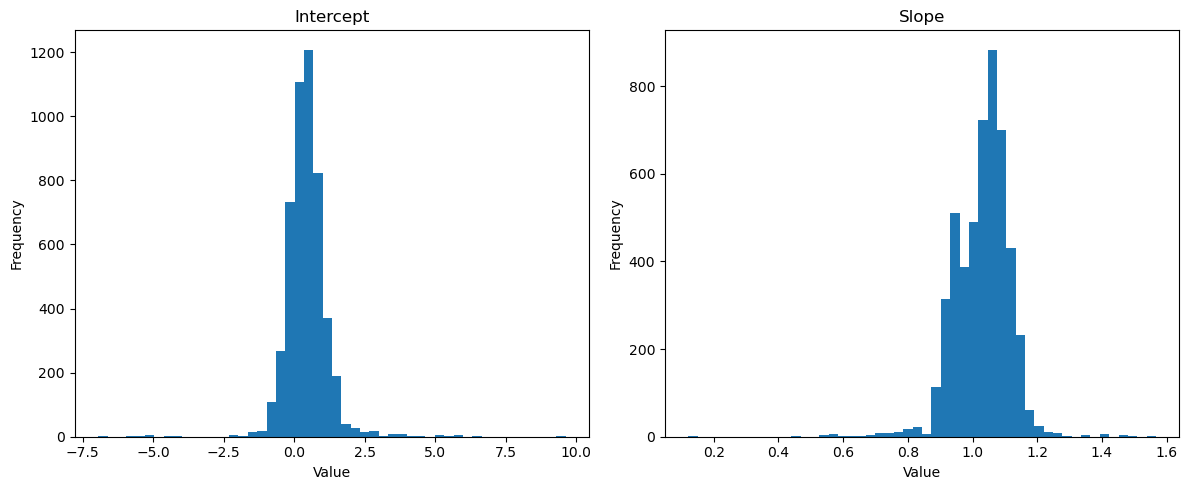

Bootstrap 95% parameter confidence intervals (m-, mest, m+)
Bootstrap intervals:
[[-0.68785526  0.43751524  1.78111587]
 [ 0.89542475  1.03039405  1.16027377]]


In [9]:
# Plot histograms of slope and intercept

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_m[0, :], bins=50)
plt.title('Intercept')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(all_m[1, :], bins=50)
plt.title('Slope')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Get bootstrap 95% confidence intervals (sort and find middle 95% values)
sort_m = np.sort(all_m.T, axis=0)
N_conf = int(np.floor(0.025 * nsamples))
low_95 = sort_m[N_conf, :]
high_95 = sort_m[-N_conf, :]  # end-N+1 in MATLAB becomes -N in Python
mean_m = np.mean(all_m, axis=1)

print('Bootstrap 95% parameter confidence intervals (m-, mest, m+)')
bootstrap_intervals = np.column_stack([low_95, mean_m, high_95])
print(f'Bootstrap intervals:\n{bootstrap_intervals}')

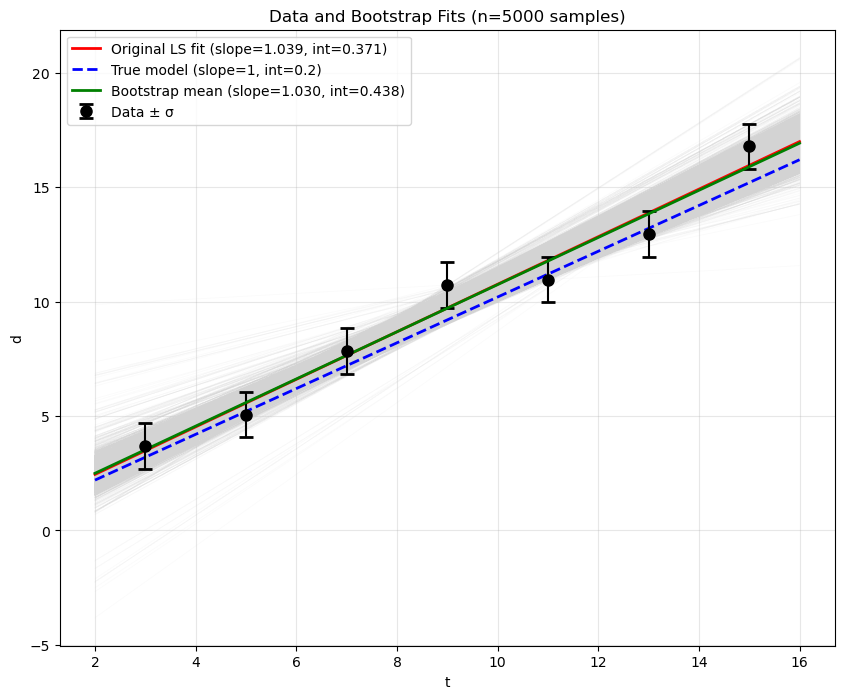

Plotted 5000 bootstrap fits
Bootstrap parameter ranges:
  Intercept: -6.948 to 9.630
  Slope: 0.121 to 1.567


In [10]:
# Plot data and all bootstrap fits

plt.figure(figsize=(10, 8))

# Create a fine grid for plotting the fits
t_plot = np.linspace(t.min() - 1, t.max() + 1, 100)

# Plot all bootstrap fits as light gray lines
for k in range(nsamples):
    intercept_boot = all_m[0, k]
    slope_boot = all_m[1, k]
    fit_boot = intercept_boot + slope_boot * t_plot
    plt.plot(t_plot, fit_boot, 'lightgray', alpha=0.1, linewidth=0.5)

# Plot the original least-squares fit
fit_original = m[0] + m[1] * t_plot
plt.plot(t_plot, fit_original, 'red', linewidth=2, label=f'Original LS fit (slope={m[1]:.3f}, int={m[0]:.3f})')

# Plot the true model
fit_true = intercept + slope * t_plot
plt.plot(t_plot, fit_true, 'blue', linewidth=2, linestyle='--', label=f'True model (slope={slope}, int={intercept})')

# Plot the data points with error bars
plt.errorbar(t, d, yerr=sigma, fmt='ko', capsize=5, capthick=2, markersize=8, label='Data ± σ')

# Add bootstrap mean fit
mean_fit = mean_m[0] + mean_m[1] * t_plot
plt.plot(t_plot, mean_fit, 'green', linewidth=2, label=f'Bootstrap mean (slope={mean_m[1]:.3f}, int={mean_m[0]:.3f})')

plt.xlabel('t')
plt.ylabel('d')
plt.title(f'Data and Bootstrap Fits (n={nsamples} samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Plotted {nsamples} bootstrap fits")
print(f"Bootstrap parameter ranges:")
print(f"  Intercept: {all_m[0,:].min():.3f} to {all_m[0,:].max():.3f}")
print(f"  Slope: {all_m[1,:].min():.3f} to {all_m[1,:].max():.3f}")